# Coronavirus testing locations in California

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import shapely
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
SQMETERS_TO_SQMI = 2590000

### Import testing locations from state map, which uses to Esri API endpoints

In [3]:
# map front end: https://www.arcgis.com/apps/Nearby/index.html?appid=43118dc0d5d348d8ab20a81967a15401
# community: https://services.arcgis.com/8ZpVMShClf8U8dae/arcgis/rest/services/TestingLocations_public2/FeatureServer/0
# state: https://services.arcgis.com/BLN4oKB0N1YSgvY8/arcgis/rest/services/State_Test_Sites/FeatureServer/0

### Read state-sponsored locations

In [106]:
# !agsout -s input/services.txt -o input

In [107]:
state = gpd.read_file('input/State_Test_Sites/State_Test_Sites_1589559599829.geojson')

In [108]:
state.columns = state.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [109]:
state.iloc[0]

objectid                                                       3
globalid                    0a3c99f8-4e79-41ee-a307-94d2b22ca10f
county                                                     Butte
address                                             2357 Fair St
city                                                       Chico
zipcode                                                    95928
hoursofoperation                                       0700-1900
operator                                              OPTUMServe
sitename                                            OPTUMServe 1
website                            https://lhi.care/covidtesting
daysofoperation                       Mon, Tues, Wed, Thurs, Fri
publicphone                                       (888) 634-1123
geometry            POINT (-121.8130604997285 39.71829599981998)
Name: 0, dtype: object

### What share are OPTUMServe vs. Verily?

In [110]:
(state['operator'].value_counts('normalize')*100).round(2).astype(str) + '%'

OPTUMServe    86.05%
Verily        13.95%
Name: operator, dtype: object

### What share are in each county?

In [111]:
(state['county'].value_counts('normalize')*100).round(2).astype(str) + '%'

Los Angeles        11.63%
Riverside          10.47%
Santa Clara         4.65%
Orange              4.65%
Kern                4.65%
San Bernadino       3.49%
San Diego           3.49%
Santa Barbara       3.49%
Alameda             3.49%
Contra Costa        3.49%
Stanislaus          3.49%
Placer              2.33%
Sonoma              2.33%
Ventura             2.33%
Tulare              2.33%
San Luis Obispo     2.33%
Monterey            2.33%
San Joaquin         2.33%
El Dorado           2.33%
Solano              2.33%
Fresno              2.33%
Marin               1.16%
Napa                1.16%
San Benito          1.16%
Butte               1.16%
San Mateo           1.16%
Mariposa            1.16%
Santa Cruz          1.16%
Tehama              1.16%
Merced              1.16%
Yolo                1.16%
Sacramento          1.16%
Nevada              1.16%
Kings               1.16%
Sutter              1.16%
Humboldt            1.16%
Shasta              1.16%
Imperial            1.16%
Name: county

In [112]:
state.iloc[0]

objectid                                                       3
globalid                    0a3c99f8-4e79-41ee-a307-94d2b22ca10f
county                                                     Butte
address                                             2357 Fair St
city                                                       Chico
zipcode                                                    95928
hoursofoperation                                       0700-1900
operator                                              OPTUMServe
sitename                                            OPTUMServe 1
website                            https://lhi.care/covidtesting
daysofoperation                       Mon, Tues, Wed, Thurs, Fri
publicphone                                       (888) 634-1123
geometry            POINT (-121.8130604997285 39.71829599981998)
Name: 0, dtype: object

### Read broader list of community testing locations

In [113]:
community_all = gpd.read_file('input/TestingLocations_public2/TestingLocations_public2_1589559606758.geojson')

In [114]:
community_all.columns = community_all.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [115]:
community_all['type_of_test'] = np.where((community_all['type_of_test'] == 'Both'),\
                                         'both',community_all['type_of_test'])

### Select from Esri list places 1) in CA and 2) listed as 'open' and 3) perform molecular testing

In [116]:
community = pd.DataFrame(community_all[(community_all['state'] == "CA") & \
                                      (community_all['status'] == "Open") & \
                                      ((community_all['type_of_test'] == "molecular") | \
                                       (community_all['type_of_test'] == "both"))])

In [117]:
len(community)

357

In [118]:
community.iloc[100]

objectid                                                                2869
facilityid                                                              None
name                                                  Hilltop Medical Clinic
fulladdr                                1093 Hilltop Dr., Redding, CA. 96001
municipality                                                         Redding
agency                                                                  None
agencytype                                                              None
phone                                                           530-246-4629
agencyurl                                  https://hilltopmedicalclinic.com/
operhours                                        7 days a week 8 AM- 5:45 PM
comments                                 Telemedicine services are available
instructions               If You Are Contagious\nPlease go to East Clini...
numvehicles                                                              NaN

### Clean up the 'type of test' field

In [119]:
(community.referral_required.value_counts('normalize')*100).round(2).astype(str) + '%'

Yes    54.42%
No      44.9%
        0.68%
Name: referral_required, dtype: object

In [120]:
community.type_of_test.value_counts()

molecular    357
Name: type_of_test, dtype: int64

In [121]:
community.agencytype.value_counts()

Private        113
County          57
Non Profit      27
Municipal       14
Other           10
State            6
Regional         6
Tribal           4
School           4
Clinic           1
Urgent Care      1
Name: agencytype, dtype: int64

In [122]:
community[community.agencytype == 'Private'].head()

,objectid,facilityid,name,fulladdr,municipality,agency,agencytype,phone,agencyurl,operhours,comments,instructions,numvehicles,testcapacity,status,creationdate,editdate,drive_through,appt_only,referral_required,services_offered_onsite,call_first,virtual_screening,health_dept_url,state,globalid,data_source,county,red_flag,vol_note,public_form,start_date,end_date,type_of_test,test_processing,fine_print,geometry
100,101,None,Carbon Health,"411 Grand Ave , Oakland 94610 CA",Oakland,Carbon Health,Private,(510) 844-4097,https://carbonhealth.com/oakland,Everyday 8:00 AM – 6:00 PM,None,"A doctor’s order is not needed, but Carbon Hea...",NaN,NaN,Open,1.585176e+12,1588374068723,No,None,None,None,None,None,https://www.cdph.ca.gov/,CA,35600c8e-c0f6-4731-a8ff-ef9814102a53,None,Alameda,None,None,None,NaN,NaN,molecular,lab,None,POINT (-122.25346 37.80866)
513,1148,None,Community Hospital of the Monterey Peninsula,"23625 Holman Hwy, Monterey, CA 93940",Monterey,Montage Health,Private,(831) 622-8001,https://www.chomp.org,24hrs,"Currently, criteria for testing include the pr...",Testing for the novel coronavirus that causes ...,NaN,NaN,Open,1.585359e+12,1588206935170,No,None,None,testing only,None,None,https://www.cdph.ca.gov/,CA,c66dae54-8a41-43fc-b757-16092c153a5e,None,Monterey,None,None,None,NaN,NaN,molecular,lab,None,POINT (-121.91521 36.57916)
1062,1842,None,Priority Urgent Care,"1345 Allen Rd #300 Bakersfield, CA 93314","Bakersfield, CA",Priority Urgent Care,Private,(661) 556-4777,https://www.priority661.com/coronavirus-covid-...,Mon-Fri: 9am-9pm Sat-Sun: 9am-6pm,None,Do you think you have COVID-19 or want to be t...,NaN,NaN,Open,1.585505e+12,1588207024931,No,Yes,No,screening and testing,Yes,None,https://kernpublichealth.com/2019-novel-corona...,CA,f1add099-4b0b-4a59-9393-d633e07a9de0,None,Kern,None,None,None,NaN,NaN,molecular,lab,None,POINT (-119.14603 35.37159)
1064,1844,None,Priority Urgent Care,"2509 Mt Vernon Ave #107 Bakersfield, CA 93306","Bakersfield, CA",Priority Urgent Care,Private,(661) 556-4777,https://www.priority661.com/coronavirus-covid-...,Mon-Frid: 8am-8pm Sat-Sun: 8am-5pm,None,Do you think you have COVID-19 or want to be t...,NaN,NaN,Open,1.585505e+12,1588207025260,No,Yes,No,screening and testing,Yes,None,https://kernpublichealth.com/2019-novel-corona...,CA,02a90d8d-fffe-45ad-9991-3fbd155b296c,None,Kern,None,None,None,NaN,NaN,molecular,lab,None,POINT (-118.96577 35.39094)
1066,1846,None,Priority Urgent Care,"4821 Panama Lane Bakersfield, CA 93313","Bakersfield, CA",Priority Urgent Care,Private,(661) 556-4777,https://www.priority661.com/coronavirus-covid-...,Mon-Frid: 8am-8pm Sat-Sun: 8am-5pm,None,Do you think you have COVID-19 or want to be t...,NaN,NaN,Open,1.585506e+12,1588207025650,No,Yes,No,screening and testing,Yes,None,https://kernpublichealth.com/2019-novel-corona...,CA,bf9d995e-1739-412c-a0ac-12e9a8979d2d,None,Kern,None,None,None,NaN,NaN,molecular,lab,None,POINT (-119.05603 35.29511)


In [123]:
community_nodoctor = community[community['referral_required'] != 'Yes']

In [124]:
len(community_nodoctor)

197

In [125]:
def alert(c):
  if c['referral_required'] == 'Yes':
    return 'partially_accessible'
  elif c['agencytype'] == 'Private':
    return 'partially_accessible'
  else:
    return 'accessible'

community['alert'] = community.apply(alert, axis=1)

In [126]:
community.alert.value_counts()

partially_accessible    207
accessible              150
Name: alert, dtype: int64

### What share of these locations are public vs. private? 

In [127]:
(community['agencytype'].value_counts('normalize')*100).round(2).astype(str) + '%'

Private         46.5%
County         23.46%
Non Profit     11.11%
Municipal       5.76%
Other           4.12%
State           2.47%
Regional        2.47%
Tribal          1.65%
School          1.65%
Clinic          0.41%
Urgent Care     0.41%
Name: agencytype, dtype: object

### What share of them are various named types of facilities?

In [128]:
(community['agency'].value_counts('normalize')*100).round(2).astype(str) + '%'

UCLA Health                                       7.04%
LA County                                         6.67%
Family Health Centers of San Diego                6.67%
MedPost Urgent Care                                6.3%
OPTUMServe & State of CA                          4.81%
Ventura County Public Health                      4.44%
OptumServe & State of CA                          4.44%
One Medical                                       3.33%
OPTUMServe                                        3.33%
City of Los Angeles                               3.33%
County of Los Angeles                             3.33%
Sharp Rees-Stealy                                 2.59%
Accelerated Urgent Care                           2.59%
Project Baseline by Verily                        2.59%
Providence                                        2.22%
OptumServe                                        1.85%
Sutter Health                                     1.85%
Carbon Health                                   

---

### Merge the 'state' and 'community' dataframes into one table with common fields

In [129]:
community['site_type'] = 'community'

In [130]:
state['site_type'] = 'state'

In [131]:
state['alert'] = 'accessible'

In [132]:
state['fulladdr'] = state['address'] + ', ' + state['city'] + ', CA ' + state['zipcode'].astype(str)

In [133]:
community.head()

,objectid,facilityid,name,fulladdr,municipality,agency,agencytype,phone,agencyurl,operhours,comments,instructions,numvehicles,testcapacity,status,creationdate,editdate,drive_through,appt_only,referral_required,services_offered_onsite,call_first,virtual_screening,health_dept_url,state,globalid,data_source,county,red_flag,vol_note,public_form,start_date,end_date,type_of_test,test_processing,fine_print,geometry,alert,site_type
100,101,None,Carbon Health,"411 Grand Ave , Oakland 94610 CA",Oakland,Carbon Health,Private,(510) 844-4097,https://carbonhealth.com/oakland,Everyday 8:00 AM – 6:00 PM,None,"A doctor’s order is not needed, but Carbon Hea...",NaN,NaN,Open,1.585176e+12,1588374068723,No,None,None,None,None,None,https://www.cdph.ca.gov/,CA,35600c8e-c0f6-4731-a8ff-ef9814102a53,None,Alameda,None,None,None,NaN,NaN,molecular,lab,None,POINT (-122.25346 37.80866),partially_accessible,community
206,1110,None,Ampla Health,"1000 Sutter Street, Yuba City, CA 95991",Sutter,Benjamín H. Flores,Non Profit,(530) 812-2031,https://www.yuba.org/coronavirus/Screening_Tes...,Screening and testing Monday - Friday.,Follow signs through outdoor back parking lot.,Please call (530) 812-2031 first so mobile uni...,NaN,NaN,Open,1.585352e+12,1588206929420,Yes,Yes,Yes,None,None,None,https://www.cdph.ca.gov/,CA,9806193f-bc55-43f7-8de3-6a0826ffe285,None,Sutter,None,None,None,NaN,NaN,molecular,lab,None,POINT (-121.61320 39.14449),partially_accessible,community
227,11066,None,Santa Monica College (SMU - Airport Satellite ...,"2800 Airport Ave. Santa Monica, CA 90405",Santa Monica,OptumServe,None,None,https://lhi.care/covidtesting,None,OptumServe Testing Sites are powered by OptumS...,Make an appointment at:https://lhi.care/covidt...,NaN,NaN,Open,1.588968e+12,1588967920594,No,Yes,No,testing only,No,Required,http://publichealth.lacounty.gov/media/coronav...,CA,eddd3f74-0ec2-415f-9aaf-bf47007fb4f9,https://covid19.lacounty.gov/testing/,Los Angeles,no,None,no,NaN,NaN,molecular,None,no,POINT (-118.45283 34.01249),accessible,community
228,11067,None,ChapCare Vacco Health Center,"10408 Vacco St., Suite A South El Monte, CA 91...",El Monte,OptumServe,None,None,https://lhi.care/covidtesting,None,OptumServe Testing Sites are powered by OptumS...,Make an appointment at:https://lhi.care/covidt...,NaN,NaN,Open,1.588968e+12,1588968195426,No,Yes,No,testing only,No,Required,http://publichealth.lacounty.gov/media/coronav...,CA,143700db-bf56-4b63-9d75-1ab3ff93ac25,https://covid19.lacounty.gov/testing/,Los Angeles,no,None,no,NaN,NaN,molecular,offsite lab,no,POINT (-118.04449 34.04715),accessible,community
229,11068,None,Baldwin Hills Crenshaw Plaza,3650 W. Martin Luther King Jr. Blvd. Los Angel...,Los Angeles,City of Los Angeles,Municipal,None,https://lacovidprod.service-now.com/rrs,None,LA City and County Testing Sites are operated ...,An appointment is required - no drop-ins are a...,NaN,NaN,Open,1.588969e+12,1588968900221,None,Yes,No,testing only,No,Required,http://publichealth.lacounty.gov/media/coronav...,CA,33d5cab9-bb6e-4209-a468-a6abdd133981,https://covid19.lacounty.gov/testing/,Los Angeles,no,None,no,NaN,NaN,molecular,None,no,POINT (-118.33682 34.01084),accessible,community


In [134]:
community_slim = community[community['alert'] == 'accessible']\
[[ 'name','fulladdr','agency','phone','globalid','geometry', 'site_type', 'alert']]

In [135]:
community_slim = community_slim.rename(columns={"name": "sitename"})

In [136]:
state_slim = state[[ 'sitename','fulladdr','operator','publicphone','globalid','geometry', 'site_type', 'alert' ]]

In [137]:
state_slim = state_slim.rename(columns={"publicphone": "phone", "operator": "agency",})

In [138]:
community_slim.head()

,sitename,fulladdr,agency,phone,globalid,geometry,site_type,alert
227,Santa Monica College (SMU - Airport Satellite ...,"2800 Airport Ave. Santa Monica, CA 90405",OptumServe,None,eddd3f74-0ec2-415f-9aaf-bf47007fb4f9,POINT (-118.45283 34.01249),community,accessible
228,ChapCare Vacco Health Center,"10408 Vacco St., Suite A South El Monte, CA 91...",OptumServe,None,143700db-bf56-4b63-9d75-1ab3ff93ac25,POINT (-118.04449 34.04715),community,accessible
229,Baldwin Hills Crenshaw Plaza,3650 W. Martin Luther King Jr. Blvd. Los Angel...,City of Los Angeles,None,33d5cab9-bb6e-4209-a468-a6abdd133981,POINT (-118.33682 34.01084),community,accessible
230,County of LA – Crenshaw Area Office,"3606 W. Exposition Blvd. Los Angeles, CA 90016",OptumServe,None,2cae6135-03c3-4882-b4ae-4cdd7e35073d,POINT (-118.33557 34.02227),community,accessible
236,OptumServe Testing Center,"1681 E Monte Vista Ave, Vacaville, CA 95688",OptumServe & State of CA,(888) 634-1123,58e25f7d-c8e5-400e-9c73-3ab431fb4b9c,POINT (-121.96279 38.37069),community,accessible


In [139]:
all_sites = pd.concat([state_slim, community_slim])

In [140]:
# all_sites.crs = {'init' :'epsg:3310'}
# all_sites.to_crs({'init': 'epsg:3310'}, inplace=True)

In [141]:
# all_sites = all_sites[all_sites['site_type'] == 'state']

In [142]:
all_sites_proj = all_sites.copy()

In [143]:
all_sites_proj['geometry'] = all_sites_proj['geometry'].to_crs(epsg=3310)

In [144]:
all_sites_proj.crs = {'init' :'epsg:3310'}
all_sites_proj.to_crs({'init': 'epsg:3310'}, inplace=True)

---

### CA county geography

In [145]:
county_geo = gpd.read_file('input/ca-counties.geojson')
county_geo.columns = county_geo.columns.str.lower()

### LA County communities

In [146]:
la_communities_geo = gpd.read_file('input/lac_cities_no_islands.shp')
la_communities_geo.columns = la_communities_geo.columns.str.lower()
la_communities_geo.crs = {'init' :'epsg:4326'}
la_communities_geo.to_crs({'init': 'epsg:4326'}, inplace=True)

### CA tracts geography

In [147]:
ca_tracts = gpd.read_file('input/tracts3310.geojson')
ca_tracts.columns = ca_tracts.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Merge population data to tracts geo file

In [148]:
# !censusdatadownloader --data-dir input --year 2018 population tracts
# !censusdatadownloader --data-dir input --year 2010 population tracts

In [149]:
tractspop = pd.read_csv('input/processed/acs5_2018_population_tracts.csv',
                       dtype={'geoid': str, 'state': str, 'county': str} )

In [150]:
tracts_geo = ca_tracts.merge(tractspop, on='geoid', how='inner')

### Clean up tracts dataframe

In [151]:
tracts_geo[['tract_name', 'place', 'state']] = tracts_geo.name_y.str.split(", ",expand=True,)

In [152]:
tracts_geo = tracts_geo.drop(['name_x', 'namelsad','mtfcc', 'funcstat', 'aland', 'awater', 'intptlat', \
                              'intptlon', 'tractce','universe_annotation', 'universe_moe', \
                              'universe_moe_annotation', 'statefp', 'countyfp', 'name_y', 'state'], axis=1)

In [153]:
tracts_geo.rename(columns={'universe':'population'}, inplace=True)

In [154]:
tracts_geo['tract_area'] = tracts_geo['geometry'].area / SQMETERS_TO_SQMI

---

### Add a buffers around each testing site of 20 miles

In [155]:
miles20 = 32000
miles10 = 16000

In [156]:
all_sites_proj['geometry'] = all_sites_proj.buffer(miles20)

In [157]:
all_sites_proj['circle_area'] = (all_sites_proj['geometry'].area / SQMETERS_TO_SQMI).round()

In [158]:
all_sites_proj.head(2)

,sitename,fulladdr,agency,phone,globalid,geometry,site_type,alert,circle_area
0,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,"POLYGON ((-123340.096 190647.278, -123494.184 ...",state,accessible,1240.0
1,OPTUMServe 1,"1 College Drive, South Lake Tahoe, CA 96150",OPTUMServe,(888) 634-1123,fd62baf9-d122-43e2-8208-5512d7ee0a11,"POLYGON ((34489.799 101196.076, 34335.710 9805...",state,accessible,1240.0


In [159]:
len(all_sites_proj)

236

In [160]:
all_sites_proj.groupby('alert')['circle_area'].aggregate(['count','sum']).reset_index()

,alert,count,sum
0,accessible,236,292640.0


In [161]:
def adddummyfield(row):
    row['alert'] = 'x'
    return row

In [162]:
dissolved_sites = all_sites_proj.apply(adddummyfield, axis=1).dissolve('alert')

In [163]:
dissolved_sites.crs = {'init':'epsg:3310'}

In [164]:
dissolved_sites.head()

,geometry,sitename,fulladdr,agency,phone,globalid,site_type,circle_area
alert,,,,,,,,
x,"MULTIPOLYGON (((447232.196 -564908.088, 447078...",OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0


In [165]:
intersection = gpd.overlay(tracts_geo, dissolved_sites, how='intersection')

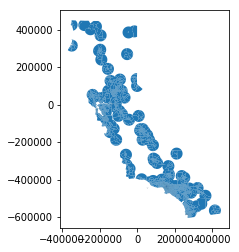

In [166]:
intersection.plot()

In [167]:
intersection.head()

,geoid,population,county,tract,tract_name,place,tract_area,sitename,fulladdr,agency,phone,globalid,site_type,circle_area,geometry
0,06001442700,3118.0,001,442700,Census Tract 4427,Alameda County,0.476461,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0,"POLYGON ((-177981.550 -51137.614, -177979.260 ..."
1,06001442800,2836.0,001,442800,Census Tract 4428,Alameda County,0.493686,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0,"POLYGON ((-176688.486 -52219.888, -176682.583 ..."
2,06001442900,7814.0,001,442900,Census Tract 4429,Alameda County,0.797886,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0,"POLYGON ((-175420.296 -53064.376, -175412.224 ..."
3,06001443001,3046.0,001,443001,Census Tract 4430.01,Alameda County,0.296807,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0,"POLYGON ((-172757.729 -52959.227, -172745.251 ..."
4,06001443002,6745.0,001,443002,Census Tract 4430.02,Alameda County,0.610162,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0,"POLYGON ((-173767.402 -53098.538, -173754.125 ..."


In [168]:
intersection['piece_area'] = intersection['geometry'].area / SQMETERS_TO_SQMI

In [169]:
intersection['pct_tract'] = intersection['piece_area'] / intersection['tract_area']

In [170]:
intersection.head(2)

,geoid,population,county,tract,tract_name,place,tract_area,sitename,fulladdr,agency,phone,globalid,site_type,circle_area,geometry,piece_area,pct_tract
0,06001442700,3118.0,001,442700,Census Tract 4427,Alameda County,0.476461,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0,"POLYGON ((-177981.550 -51137.614, -177979.260 ...",0.476461,1.0
1,06001442800,2836.0,001,442800,Census Tract 4428,Alameda County,0.493686,OPTUMServe 1,"2357 Fair St, Chico, CA 95928",OPTUMServe,(888) 634-1123,0a3c99f8-4e79-41ee-a307-94d2b22ca10f,state,1240.0,"POLYGON ((-176688.486 -52219.888, -176682.583 ...",0.493686,1.0


In [171]:
tract_pct = intersection.groupby(['tract_name', 'place'])['pct_tract'].sum().reset_index()

In [172]:
tracts_geo_merge = tracts_geo.merge(tract_pct, on=['tract_name', 'place'], how='left')

In [173]:
len(tracts_geo_merge)

8049

In [174]:
tracts_geo_merge.head()

,geoid,geometry,population,county,tract,tract_name,place,tract_area,pct_tract
0,06001442700,"MULTIPOLYGON (((-177981.550 -51137.614, -17797...",3118.0,001,442700,Census Tract 4427,Alameda County,0.476461,1.0
1,06001442800,"MULTIPOLYGON (((-176688.486 -52219.888, -17668...",2836.0,001,442800,Census Tract 4428,Alameda County,0.493686,1.0
2,06001442900,"MULTIPOLYGON (((-175420.296 -53064.376, -17541...",7814.0,001,442900,Census Tract 4429,Alameda County,0.797886,1.0
3,06001443001,"MULTIPOLYGON (((-172757.729 -52959.227, -17274...",3046.0,001,443001,Census Tract 4430.01,Alameda County,0.296807,1.0
4,06001443002,"MULTIPOLYGON (((-173767.402 -53098.538, -17375...",6745.0,001,443002,Census Tract 4430.02,Alameda County,0.610162,1.0


In [175]:
tracts_geo_merge['pop_portion'] = tracts_geo_merge['population'] - (tracts_geo_merge['population'] * tracts_geo_merge['pct_tract'])

In [176]:
tracts_geo_merge.sort_values(by='pop_portion', ascending=False).head()

,geoid,geometry,population,county,tract,tract_name,place,tract_area,pct_tract,pop_portion
1682,06029004701,"MULTIPOLYGON (((67031.746 -260842.578, 67029.5...",11270.0,029,4701,Census Tract 47.01,Kern County,3.609603,0.000067,11269.248836
1212,06039000503,"MULTIPOLYGON (((-22891.981 -115843.871, -22865...",9261.0,039,503,Census Tract 5.03,Madera County,59.173234,0.081084,8510.085091
1387,06039000201,"MULTIPOLYGON (((-20320.610 -100829.695, -20315...",8460.0,039,201,Census Tract 2.01,Madera County,40.622744,0.041854,8105.918205
5122,06073018700,"MULTIPOLYGON (((242751.620 -530493.170, 242745...",38932.0,073,18700,Census Tract 187,San Diego County,212.321986,0.795214,7972.734420
1680,06029004604,"MULTIPOLYGON (((58219.711 -247218.549, 59524.0...",14188.0,029,4604,Census Tract 46.04,Kern County,209.700372,0.446331,7855.449441


In [177]:
tracts_geo_merge.pop_portion.sum()

464745.7585533891

### How many "accessible" test sites are in each of these geographic locations?

#### CA counties 

In [178]:
county_geo_merge = gpd.sjoin(all_sites, county_geo, op='intersects')

In [179]:
county_geo_merge_group = county_geo_merge.groupby(['name']).agg('size').reset_index(name='sites')

In [188]:
county_geo_merge_group.sort_values(by='sites', ascending=False).head(10)

,name,sites
12,Los Angeles,60
20,Orange,13
22,Riverside,11
42,Ventura,10
9,Kern,9
0,Alameda,9
6,Fresno,8
34,Shasta,8
26,San Diego,7
35,Siskiyou,6


#### L.A. County communities

In [181]:
la_communities_dissolve = la_communities_geo.dissolve(by='city_name').reset_index()

In [182]:
la_communities_geo_merge = gpd.sjoin(all_sites, la_communities_dissolve, op='intersects')

In [183]:
la_communities_geo_merge_group = la_communities_geo_merge.groupby(['city_name'])\
    .agg('size').reset_index(name='sites')

In [184]:
la_communities_geo_merge_group.sort_values(by='sites', ascending=False).head(10)

,city_name,sites
11,Los Angeles,19
10,Long Beach,6
23,Unincorporated,5
15,Pasadena,3
2,Commerce,2
21,South El Monte,2
7,Hawthorne,2
20,Santa Monica,2
9,Lancaster,2
0,Bell,1


### Export to CSVs

In [185]:
tracts_testing_counts.to_csv('output/tracts_testing_counts.csv')

In [186]:
county_geo_merge_group.to_csv('output/counties_testing_counts.csv')

In [187]:
la_communities_geo_merge_group.to_csv('output/la_communities_testing_counts.csv')

### Merge testing counts back polygons for tracts, counties, communities

### Export respective geographic files

### Everything merge OK?

---

### Eventually output to Mapbox

In [88]:
# !tippecanoe --generate-ids --force -r1 -pk -pf -o \
# output/tracts_testing_counts_geo.mbtiles \
# output/tracts_testing_counts_geo.geojson

In [89]:
# !tippecanoe --generate-ids --force -r1 -pk -pf -o \
# output/county_testing_counts_geo.mbtiles \
# output/county_testing_counts_geo.geojson

In [90]:
# !tippecanoe --generate-ids --force -r1 -pk -pf -o \
# output/la_communities_testing_counts_geo.mbtiles \
# output/la_communities_testing_counts_geo.geojson